# Simple Self Contained Model of the Funcspec Project

## Imports

In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision.datasets import EMNIST
import numpy as np
from tqdm.notebook import tqdm as tqdm_n
import matplotlib.pyplot as plt
import seaborn as sns
from torchviz import make_dot
from torchsummary import summary
from torch.utils.data import DataLoader


In [ ]:
%load_ext autoreload
%autoreload 2

## Data

### Datasets

In [7]:
from community.data.datasets import get_datasets_alphabet
from community.common.utils import plot_grid


In [13]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
n_classes = 2
task = 'parity'


In [9]:
#Digits and Letters
multi_loaders, double_loaders_dig, double_loaders_letters, single_loaders, letters = get_datasets_alphabet('../../data', batch_size, use_cuda, fix_asym=False, n_classes=n_classes, split_classes=True)
loaders = multi_loaders

In [18]:
loaders[0].dataset.datasets

[Dataset MNIST
     Number of datapoints: 60000
     Root location: ../../data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ),
 Dataset Custom_EMNIST
     Number of datapoints: 110400
     Root location: ../../data
     Split: Train
     StandardTransform
 Transform: Compose(
                <function get_datasets_alphabet.<locals>.<lambda> at 0x7fe5ed89a170>
                <function get_datasets_alphabet.<locals>.<lambda> at 0x7fe4df1e9090>
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            )]

### Task

In [10]:
def get_task_target(target, task) : 
    try :
        task = int(task)
        new_target = target[:, task]
    except ValueError : 

        if task == 'parity': 
            new_target = parity_task(target)
        elif task == 'symbols' : 
            new_target = symbol_count(target)
        else : 
            raise NotImplementedError

    return new_target.type(torch.LongTensor).to(target.device)

def parity_task(target) : 

    parity = 1 - target.sum(-1)%2
    parity_target = torch.where(parity.bool(), target[:, 0], target[:, 1])
    return parity_target

def new_parity_task(target) : 
    parity = 1 - target.sum(-1)%2
    equal = (target[:, 0].eq(target[:, 1]))
    parity_target = torch.where(parity.bool(), target[:, 0], target[:, 1])
    parity_target = torch.where(equal, torch.full_like(parity_target, n_classes), parity_target)

    return parity_target


def process_data(data, nb_steps=None, flatten=True, symbols=True, device=device) : 
    if symbols : data =  data.permute(2, 1, 0, 3, 4)
    if flatten : data = data.flatten(start_dim=-2) 
    if nb_steps : data = torch.stack([data for _ in range(nb_steps)], 1)
    
    return data.float().to(device)
    

def get_data(temporal=False, task=None, flatten=True, device=device) : 
    data, target = next(iter(loaders[0]))
    data = process_data(data, flatten=flatten, nb_steps=2 if temporal else None)
    if task : target = get_task_target(target, task)

    return data, target.float().to(device)


def symbol_count(target) : 
    new_target = torch.where(target.argmax(-1).bool(), target[:, 1], target[:, 0])
    new_target[target[:, 0] == target[:, 1]] = 0
    return new_target


### Data plotting

In [14]:
class_split = ([d.truncate_values for d in loaders[0].dataset.datasets])
idxs = [[(d.targets == c).float().argmax() for c in range(n_classes)] for d in loaders[0].dataset.datasets]
datas = [[d[i][0] for i in idx] for d, idx in zip(loaders[0].dataset.datasets, idxs)]
plot_grid(datas, figsize=(n_classes, 3))


AttributeError: 'MNIST' object has no attribute 'truncate_values'

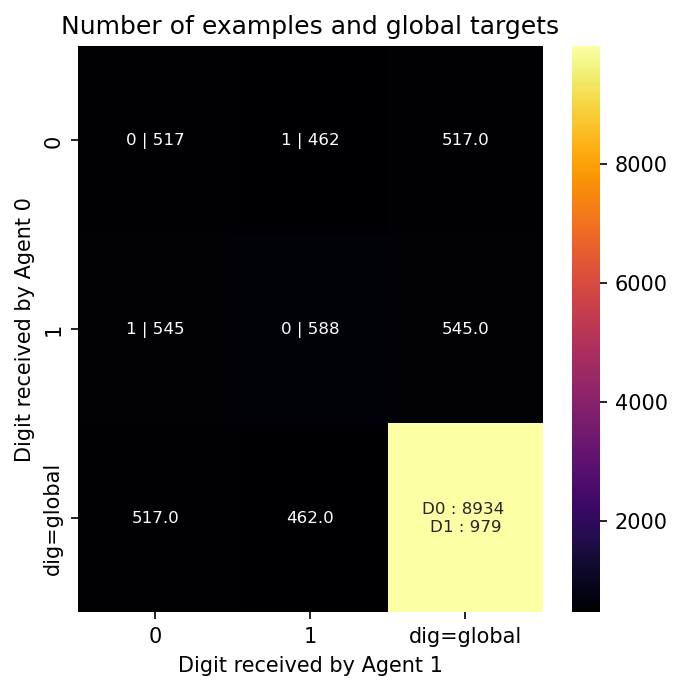

In [12]:
if True : 
        
    get_all_targets = lambda : torch.cat([t for _, t in loaders[1]])
    all_targets = get_all_targets()
    uniques, unique_counts = all_targets.unique(dim=0, return_counts=True)
    task_t = get_task_target(all_targets, task)
    task_t.unique(dim=0, return_counts=True), (all_targets[:, 0] == task_t).unique(dim=0, return_counts=True), (all_targets[:, 1] == task_t).unique(dim=0, return_counts=True)
    digits_in = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).any()
    digits_idx = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).float().argmax()
    counts = np.zeros((n_classes+1, n_classes+1))
    targets = np.zeros((n_classes+1, n_classes+1), dtype=object)

    for d1 in range(n_classes) : 
        counts[d1, -1] = ((all_targets[:, 0] == task_t)[all_targets[:, 0] == d1]).sum() #unique_counts[(uniques == d1)[:, 0]].sum()
        targets[d1, -1] = str( counts[d1, -1])
        for d2 in range(n_classes) : 
            if digits_in(d1, d2) : 
                counts[d1, d2] = unique_counts[digits_idx(d1, d2)]
                targets[d1, d2] = f'{get_task_target(uniques, task)[digits_idx(d1, d2)].cpu().data.item()} | {unique_counts[digits_idx(d1, d2)]}'
            else : 
                counts[d1, d2] = -0.1
                targets[d1, d2] = 'X'
            counts[-1, d2] = ((all_targets[:, 1] == task_t)[all_targets[:, 1] == d2]).sum() #unique_counts[(uniques == d2)[:, 1]].sum()
            targets[-1, d2] = str( counts[-1, d2])

    counts[-1, -1] = unique_counts.sum().cpu().data.item()
    targets[-1, -1] = str(f'D0 : {(all_targets[:, 0] == task_t).unique(dim=0, return_counts=True)[1][1]} \n' + 
                    f'D1 : {(all_targets[:, 1] == task_t).unique(dim=0, return_counts=True)[1][1]}')
                
    plt.figure(figsize=(5, 5), dpi=150)
    ax = sns.heatmap(counts, cmap="inferno", annot=targets, annot_kws={'fontsize': 8}, fmt='s')
    ax.set_title('Number of examples and global targets')

    ax.set_xlabel('Digit received by Agent 1')
    ax.set_ylabel('Digit received by Agent 0')
    ax.set_xticklabels([str(i) for i in range(n_classes)] + ['dig=global'])
    ax.set_yticklabels([str(i) for i in range(n_classes)] + ['dig=global'])

    plt.show()


## Models

In [6]:
class SmoothStep(torch.autograd.Function):
    '''
    Modified from: https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
    '''

    @staticmethod
    def forward(aux, x, thr=0):
        aux.save_for_backward(x)
        return (x >=thr).type(x.dtype)

    def backward(aux, grad_output):
        # grad_input = grad_output.clone()
        input, = aux.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input <= -.5] = 0
        grad_input[input > .5] = 0
        return grad_input
    
smooth_step = SmoothStep().apply
sigmoid = nn.Sigmoid()

class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input, thr=0):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = -torch.ones_like(input)
        out[input > thr] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
super_spike  = SurrGradSpike.apply

In [23]:
class Agent(nn.Module) : 

    def __init__(self, dims, use_conv=False) : 
        super().__init__()
        if use_conv : 
            S, W, F = 1, input_size, symbol_size
            P = int(((S-1)*W-S+F)/2)
            print(F, S, P)
            self.conv = nn.Sequential(nn.Conv2d(1, 1, F, S, P), nn.Flatten())
        else : 
            self.conv = None

        self.cell = nn.RNN(dims[0], dims[1], 1, bias=False, batch_first=False)
        self.readout = nn.Linear(dims[1], dims[2], bias=False)

    def forward(self, input, state=None, connections=0) : 

        if self.conv : 
            input = self.conv(input)

        if len(input.shape ) < 3 : 
            input = input.unsqueeze(0)

        if state is None : 
            out, h = self.cell(input)
        else : 
            h = state + connections
            out, h = self.cell(input, h)

        out = self.readout(out[0])

        return out, h

class Connection(nn.Linear) : 
    def __init__(self, dims, p, binarize=False) : 

        super().__init__(dims[0], dims[1], bias=False)

        self.sparsity = p
        n_in, n_out = dims
        self.nb_non_zero = int(p*n_in*n_out)
        w_mask = np.zeros((n_in, n_out),dtype=bool)
        ind_in, ind_out = np.unravel_index(np.random.choice(np.arange(n_in*n_out), self.nb_non_zero, replace=False), (n_in, n_out))
        w_mask[ind_in,ind_out] = True
        w_mask = torch.tensor(w_mask)
        self.register_buffer('w_mask', w_mask)
        self.binarize = binarize

        assert w_mask.sum() == self.nb_non_zero, f'Number of nonzero connection is {w_mask.sum()}, expected {self.nb_non_zero}'

    def forward(self, input) : 
        out = F.linear(input, self.weight*self.w_mask)
        assert (out != 0).float().sum(-1).max() <= self.nb_non_zero, f'{(out != 0).float().sum(-1).max()} non zero connections !'
        if self.binarize  : 
            out = super_spike(out)

        return out

class Ensemble(nn.Module) : 
    def __init__(self, dims, p, use_conv=False, binary_con=False) : 

        super().__init__()
        self.n_in, self.n_hid, self.n_out = dims
        self.agents = nn.ModuleList([Agent(dims, use_conv) for _ in range(2)])[::-1]
        self.connections = nn.ModuleList([Connection([dims[1]]*2, p, binary_con) for _ in range(2)])

    def forward(self, input): 

        states, outputs, conns = [None for _ in range(2)], [[] for _ in range(2)], [None for _ in range(2)]
        
        for t, t_input in enumerate(input) :
            for ag, agent in enumerate(self.agents) : 
                
                ag_input = t_input[ag]
                
                if t>0 : 
                    input_connect = self.connections[1-ag](states[1-ag])
                else : 
                    input_connect = 0
                
                out, h = agent(ag_input, states[ag], input_connect)


                states[ag] = h
                outputs[ag].append(out)
                conns[ag] = input_connect

        outputs = torch.stack([torch.stack(o) for o in outputs], 1)
        states = torch.stack(states, 1)[0]
        conns = torch.stack(conns, 1)[0]

        #print((outputs[-1][1] == outputs[-1][1]).all())

        return outputs, states, conns
     

## Decisions


In [24]:
def get_decision(outputs, decision_params, target=None) : 
    temporal_decision, agent_decision = decision_params

    if temporal_decision == 'last' : 
        outputs = outputs[-1]

    else : 
        raise NotImplementedError

    try : 
        deciding_ags = int(agent_decision)
        outputs = outputs[deciding_ags]
        deciding_ags = torch.ones(outputs.shape[0])*deciding_ags
        return outputs, deciding_ags

    except ValueError : 

        if agent_decision == 'loss' :
            assert target is not None, 'Provide target for min loss decision'
            loss, min_idxs = torch.stack([F.cross_entropy(out, target, reduction='none') for out in outputs]).min(0)
            min_idxs = min_idxs.unsqueeze(-1).expand_as(outputs[0])
            outputs = torch.where(~min_idxs.bool(), outputs[0], outputs[1])
            deciding_ags = min_idxs[..., 0]
            return outputs, deciding_ags

        elif agent_decision == 'max' : 
            device = outputs.device
            n_agents = outputs.shape[0]
            max_out = lambda i : torch.max(outputs[i,...], axis=-1)
            _, deciding_ags = torch.max(torch.stack([max_out(i)[0] for i in range(n_agents)]), axis=0)
            mask_1 = deciding_ags.unsqueeze(0).unsqueeze(-1).expand_as(outputs)
            mask_2 = torch.einsum('b, bcx -> bcx', torch.arange(n_agents).to(device), torch.ones_like(outputs))
            mask = (mask_1 == mask_2)

            return (outputs*mask).sum(0), deciding_ags

        else : 
            raise NotImplementedError

def check_grad(model, task_id = '0') : 
    for n, p in model.named_parameters() : 
        if 'k_params' in n or 'all_scores' in n : 
            if task_id in n : 
                return check_ind_grad(n, p)
        else : 
            check_ind_grad(n, p)

def check_ind_grad(n, p) : 
    if p.grad is not None : 
        if (p.grad == 0).all() : 
            ''
            print(f'{n}, Zero Grad')
        #else : print(f'{n} : {p.grad}')
    elif p.requires_grad : 
        ''
        print(f'{n}, None Grad')

## Init

In [26]:
use_symbols = False
if not use_symbols :
    input_size = 28

In [38]:
dims = [input_size**2, 50, n_classes]
sparsity = 1 * 1/dims[1]**2

use_conv = False
binary_connections = True

community = Ensemble(dims, sparsity, use_conv, binary_connections).to(device)
optimizer = torch.optim.Adam(community.parameters(), lr=1e-3)

#summary(community.agents[0], (1, input_size, input_size) if use_conv else (1, input_size**2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 1, 50], [-1, 1, 50]]               0
            Linear-2                    [-1, 2]             100
Total params: 100
Trainable params: 100
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [39]:
data, target = get_data(flatten=True, temporal = True, device=device)
out, states, conns = community(data)
if binary_connections : print(conns.unique(return_counts=True))
#symbol_count(target).unique(return_counts=True), (symbol_count(target) == target[:, 0]).unique(return_counts=True)

(tensor([-1.,  1.], device='cuda:0', grad_fn=<Unique2Backward0>), tensor([25446,   154], device='cuda:0'))


In [233]:
#make_dot(out[-1][1], dict(community.named_parameters())).render('graph')

## Training

In [40]:
n_epochs = 10

decision_params = ('last', 'max') # Change to '0', '1' or 'loss'
task = 'parity'

pbar = tqdm_n(range(n_epochs))
descs = np.full((2), '', dtype=object)

check_gradients = False

train, test = True, True

early_stop = True

#train_loader, test_loader = loaders if not symbols else symbol_loaders()
#subset = len(train_loader) if not symbols else 100000

for epoch in pbar : 
    train_loader, test_loader = loaders

    if train : 
            
        # Training

        for batch_idx, (data, target) in enumerate(train_loader) : 
            
            data = process_data(data, 2, True, use_symbols, device)
            target = get_task_target(target, task).to(device)

            optimizer.zero_grad()

            outputs, states, conns = community(data)
            #print((outputs[-1][0] == outputs[-1][1]).all())
            output, deciding_ags = get_decision(outputs, decision_params, target)

            loss = F.cross_entropy(output, target)
            loss.backward()

            if check_gradients : 
                zero_grads = np.array([((p.grad == 0).all()).cpu().data.item() for p in community.parameters() if p.grad is not None])
                none_grads = np.array([p.grad is None for p in community.parameters()])
                zero_params = np.array(list(dict(community.named_parameters()).keys()), dtype=object)[~none_grads][zero_grads]
                none_params = np.array(list(dict(community.named_parameters()).keys()), dtype=object)[none_grads]

                print(f'Zero params : {zero_params}')
                print(f'None Params : {none_params}')
                
            optimizer.step()

            pred = output.argmax(dim=-1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().cpu().data.item()
            acc = (correct / target.numel())

            descs[0] = str('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.3f}, Accuracy: {}%'.format(
                            epoch, batch_idx  * batch_size, len(train_loader.dataset) if not use_symbols else data_sizes[0],
                            100. * batch_idx / len(train_loader) if not use_symbols else 0, loss.item(),
                            (np.round(100*a) for a in acc) if type(acc) is list else np.round(100*acc))
                            )

            pbar.set_description((descs.sum()))

    if test : 
        acc = []
        for batch_idx, (data, target) in enumerate(test_loader) : 
            
            data = process_data(data, nb_steps if not use_symbols else None, True, use_symbols, device)
            target = get_task_target(target, task).to(device)

            outputs, states, conns = community(data)
            #print((outputs[-1][0] == outputs[-1][1]).all())
            output, deciding_ags = get_decision(outputs, decision_params, target)

            loss = F.cross_entropy(output, target)

            pred = output.argmax(dim=-1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().cpu().data.item()
            acc += [correct / target.numel()]

        acc = np.mean(acc)
        
        descs[1] = str('| Test : Loss: {:.3f}, Accuracy: {}%'.format(
                        loss.item(),
                        (np.round(100*a) for a in acc) if type(acc) is list else np.round(100*acc))
                        )

        pbar.set_description((descs.sum()))

    if acc > 0.95 and early_stop: 
            break
            #continue

  0%|          | 0/10 [00:00<?, ?it/s]

In [44]:
if use_conv : 
    fig, axs = plt.subplots(1, 2)
    for ag, ax in zip(community.agents, axs) : 
        im = ax.imshow((ag.conv[0].weight.data.cpu().numpy()[0, 0]))

#plt.colorbar(im)

## Analysis


### Connections

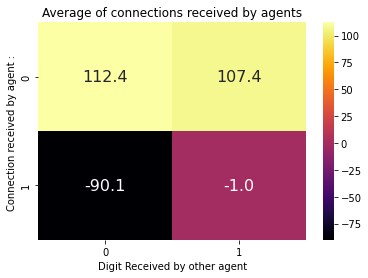

In [55]:
community.to(device)
sums = []
nonzero_idxs = [c.w_mask.nonzero()[:, 0] for c in community.connections]

for data, target in loaders[1] : 
    
    data, target = process_data(data, nb_steps if not use_symbols else None, True, use_symbols, device), target.to(device)
    out, states, conns = community(data.to(device))
    
    #conns[-1][0].count_nonzero(dim=0)
    #torch.stack([conns[-1][i].count_nonzero(dim=0).max() for i in range(2)])
    #sums.append(torch.tensor([[conns[-1][i][target[:, i] == t].sum() for t in range(4)] for i in range(2)]))
    sums.append(torch.stack([torch.stack([conns[i][target[:, 1-i] == t][:, nonzero_idxs[1-i]].sum(0) for t in range(n_classes)]) for i in range(2)]))

sums = torch.stack(sums).cpu().data.numpy().mean(0)[..., 0]
ax = sns.heatmap(sums, cmap="inferno", annot=sums.round(1).astype(str), annot_kws={'fontsize': 16}, fmt='s')
ax.set_xlabel('Digit Received by other agent')
ax.set_ylabel('Connection received by agent : ')
ax.set_title('Average of connections received by agents')
plt.show()

 ### Decisions

/tmp/ipykernel_7938/1162496303.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = target.eq(torch.tensor(t)).all(axis=1)


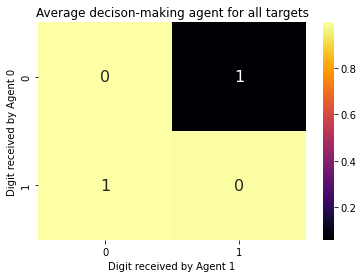

In [58]:
get_all_targets = lambda : torch.cat([t for _, t in loaders[1]])

all_targets = get_all_targets()

uniques = all_targets.unique(dim=0).cpu()
decision_means = torch.zeros(len(uniques))

community.to('cpu')
for b_idx, (data, target) in enumerate(loaders[1]) : 
    
    data, target = process_data(data, nb_steps if not use_symbols else None, True, use_symbols, 'cpu'), target.to('cpu')
    t_target = get_task_target(target, task).cpu()
    output, *_ = community(data)
    output, decision_ags = get_decision(output, decision_params, target=t_target)

    for i, t in enumerate(uniques) : 
        mask = target.eq(torch.tensor(t)).all(axis=1)
        decision_means[i] += decision_ags[mask].float().cpu().sum()/mask.sum()
decision_means /= b_idx +1

digits_in = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).any()
digits_idx = lambda d1, d2 : (torch.tensor([d1, d2]) == uniques).all(1).float().argmax()
decisions = np.zeros((n_classes, n_classes))
targets = np.zeros((n_classes, n_classes), dtype=object)

for d1 in range(n_classes) : 
    for d2 in range(n_classes) : 
        if digits_in(d1, d2) : 
            decisions[d1, d2] = decision_means[digits_idx(d1, d2)]
            targets[d1, d2] = str(get_task_target(uniques, task)[digits_idx(d1, d2)].cpu().data.item())
        else : 
            decisions[d1, d2] = -0.1
            targets[d1, d2] = 'X'
            
ax = sns.heatmap(decisions, cmap="inferno", annot=targets, annot_kws={'fontsize': 16}, fmt='s')
ax.set_title('Average decison-making agent for all targets')

ax.set_xlabel('Digit received by Agent 1')
ax.set_ylabel('Digit received by Agent 0')

plt.show()

# Whyyyy